In [1]:
from attacksplitnn.splitnn import Client, Server, SplitNN
from attacksplitnn.attack import Black_Box_Model_Inversion
from attacksplitnn.utils import DataSet

In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

from opacus import PrivacyEngine

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score

In [3]:
config = {
    "batch_size":128
}

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.random.manual_seed(42)
print(device)

cpu


In [5]:
transform = transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])

In [6]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
testset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

In [7]:
victim_idx = random.sample(range(trainset.data.shape[0]), k=2000)
victim_train_idx = victim_idx[:1000]
attack_idx = victim_idx[1000:]
victim_test_idx = random.sample(range(testset.data.shape[0]), k=15)

In [8]:
victim_train_dataset = Subset(trainset, victim_train_idx)
attack_dataset = Subset(trainset, attack_idx)
victim_test_dataset = Subset(testset, victim_test_idx)

In [9]:
victim_train_dataloader = torch.utils.data.DataLoader(victim_train_dataset, batch_size=64, shuffle=True)
attack_dataloader = torch.utils.data.DataLoader(attack_dataset, batch_size=64, shuffle=True)
victim_test_dataloader = torch.utils.data.DataLoader(victim_test_dataset, batch_size=64, shuffle=False)

In [10]:
class FirstNet(nn.Module):
    def __init__(self):
        super(FirstNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64,
                               kernel_size=3, padding=1, stride=1)
        #self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1) 
        #self.bn2 = nn.BatchNorm2d(128)

    def forward(self, x):
        # 3ch > 64ch, shape 32 x 32 > 16 x 16
        x = self.conv1(x) # [64,32,32]
        #x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2) # [64,16,16]
        
        # 64ch > 128ch, shape 16 x 16 > 8 x 8
        x = self.conv2(x) # [128,16,16]
        #x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2) # [128,8,8]
        return x

In [11]:
# CNNを実装する
class SecondNet(nn.Module):
    def __init__(self):
        super(SecondNet, self).__init__()
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.L1 = nn.Linear(512, 10) # 10クラス分類

    def forward(self, x):
        # 128ch > 256ch, shape 8 x 8 > 4 x 4
        x = self.conv3(x) # [256,8,8]
        x = self.bn3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2) # [256,4,4]   

        # 256ch > 512ch, shape 4 x 4 > 2 x 2
        x = self.conv4(x) # [512,4,4]
        x = self.bn4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2) # [512,2,2]
        # 全結合層
        x = x.view(-1, 512)
        x = self.L1(x)
        #x = F.softmax(x, dim=0)
        return x


## Train victim SplitNN

In [12]:
model_1 = FirstNet()
model_1 = model_1.to(device)

model_2 = SecondNet()
model_2 = model_2.to(device)

opt_1 = optim.Adam(model_1.parameters(), lr=1e-3)
opt_2 = optim.Adam(model_2.parameters(), lr=1e-3)

criterion = nn.CrossEntropyLoss()

In [13]:
def accuracy(label, output):
    pred = output.argmax(dim=1, keepdim=True)
    return pred.eq(label.view_as(pred)).sum().item() / pred.shape[0]

In [14]:
client = Client(model_1)
server = Server(model_2)

splitnn = SplitNN(client, server, opt_1, opt_2)

In [15]:
splitnn.train()
for epoch in range(3):
    epoch_loss = 0
    epoch_outputs = []
    epoch_labels = []
    for i, data in enumerate(victim_train_dataloader):
        splitnn.zero_grads()
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = splitnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        epoch_loss += loss.item() / len(victim_train_dataloader.dataset)
        
        epoch_outputs.append(outputs)
        epoch_labels.append(labels)
        
        splitnn.backward()
        splitnn.step()
        
    print(epoch_loss, accuracy(torch.cat(epoch_labels),
                                torch.cat(epoch_outputs)))

0.021596186965703965 0.628
0.004265135064721108 0.929
0.0015598629191517829 0.979


## Train Attacker

In [16]:
# CNNを実装する
class Attacker(nn.Module):
    def __init__(self):
        super(Attacker, self).__init__()
        self.fla = nn.Flatten()
        self.ln1 = nn.Linear(128*7*7, 1000)
        self.ln2 = nn.Linear(1000, 784)

    def forward(self, x):
        x = self.fla(x)
        x = self.ln1(x)
        x = F.relu(x)
        x = self.ln2(x)
        x = x.view(-1, 1, 28, 28)

        return x
    
attacker = Attacker()
attacker = attacker.to(device)

opt_3 = optim.Adam(attacker.parameters(), lr=1e-3)

In [17]:
bbmi = Black_Box_Model_Inversion(splitnn, attacker, opt_3)
bbmi.fit(attack_dataloader, 15)

epoch 0: reconstruction_loss 0.46572378277778625
epoch 1: reconstruction_loss 0.37234872579574585
epoch 2: reconstruction_loss 0.3032512366771698
epoch 3: reconstruction_loss 0.23519138991832733
epoch 4: reconstruction_loss 0.2174827754497528
epoch 5: reconstruction_loss 0.1884101778268814
epoch 6: reconstruction_loss 0.1857607364654541
epoch 7: reconstruction_loss 0.16860763728618622
epoch 8: reconstruction_loss 0.15324559807777405
epoch 9: reconstruction_loss 0.1531720906496048
epoch 10: reconstruction_loss 0.13798652589321136
epoch 11: reconstruction_loss 0.13458532094955444
epoch 12: reconstruction_loss 0.1284172534942627
epoch 13: reconstruction_loss 0.12144235521554947
epoch 14: reconstruction_loss 0.10912258923053741


In [18]:
attack_result = bbmi.attack(victim_test_dataloader)
attack_result = attack_result.detach().numpy()

## Attack Result

### Private data

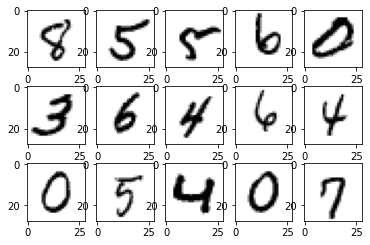

In [19]:
for data, _ in victim_test_dataloader:
    break
    
for i in range(1,16): 
    plt.subplot(3,5,i)
    plt.imshow(data[i-1].reshape(28,28),cmap='gray_r')

plt.show()

### Reconstructed data

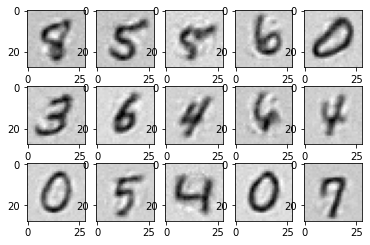

In [20]:
for i in range(1,16): 
    plt.subplot(3,5,i)
    plt.imshow(attack_result[i-1].reshape(28,28),cmap='gray_r')
#plt.title("reconstructed data")
plt.show()

## Differential Privacy

In [21]:
model_1 = FirstNet()
model_1 = model_1.to(device)

model_2 = SecondNet()
model_2 = model_2.to(device)

opt_1 = optim.Adam(model_1.parameters(), lr=1e-3)
opt_2 = optim.Adam(model_2.parameters(), lr=1e-3)

criterion = nn.CrossEntropyLoss()

privacy_engine = PrivacyEngine(
    model_1,
    sample_rate=0.5,
    alphas=[10, 100],
    noise_multiplier=1.3,
    max_grad_norm=1.0,
)
privacy_engine.attach(opt_1)
# Now it's business as usual

C:\Users\kanka\AppData\Local\Programs\Python\Python39\lib\site-packages\opacus\privacy_engine.py:522: UserWarning: A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
  warnings.warn(
C:\Users\kanka\AppData\Local\Programs\Python\Python39\lib\site-packages\opacus\privacy_engine.py:194: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
  warnings.warn(


In [22]:
client = Client(model_1)
server = Server(model_2)

splitnn = SplitNN(client, server, opt_1, opt_2)

In [23]:
splitnn.train()
for epoch in range(3):
    epoch_loss = 0
    epoch_outputs = []
    epoch_labels = []
    for i, data in enumerate(victim_train_dataloader):
        splitnn.zero_grads()
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = splitnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        epoch_loss += loss.item() / len(victim_train_dataloader.dataset)
        
        epoch_outputs.append(outputs)
        epoch_labels.append(labels)
        
        splitnn.backward()
        splitnn.step()
        
    print(epoch_loss, accuracy(torch.cat(epoch_labels),
                                torch.cat(epoch_outputs)))

C:\Users\kanka\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


0.018717604845762254 0.637
0.004171480610966683 0.941
0.001691887840628624 0.977


In [24]:
attacker = Attacker()
attacker = attacker.to(device)

opt_3 = optim.Adam(attacker.parameters(), lr=1e-3)

bbmi = Black_Box_Model_Inversion(splitnn, attacker, opt_3)
bbmi.fit(attack_dataloader, 15)

epoch 0: reconstruction_loss 0.5725551247596741
epoch 1: reconstruction_loss 0.4180929958820343
epoch 2: reconstruction_loss 0.35118165612220764
epoch 3: reconstruction_loss 0.306212455034256
epoch 4: reconstruction_loss 0.24037007987499237
epoch 5: reconstruction_loss 0.2155671864748001
epoch 6: reconstruction_loss 0.20065361261367798
epoch 7: reconstruction_loss 0.20342469215393066
epoch 8: reconstruction_loss 0.16491791605949402
epoch 9: reconstruction_loss 0.1551005095243454
epoch 10: reconstruction_loss 0.14462555944919586
epoch 11: reconstruction_loss 0.13749943673610687
epoch 12: reconstruction_loss 0.1446944922208786
epoch 13: reconstruction_loss 0.13278530538082123
epoch 14: reconstruction_loss 0.1325686275959015


In [25]:
attack_result = bbmi.attack(victim_test_dataloader)
attack_result = attack_result.detach().numpy()

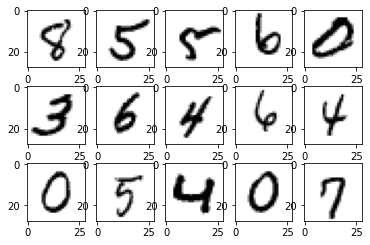

In [26]:
for data, _ in victim_test_dataloader:
    break
    
for i in range(1,16): 
    plt.subplot(3,5,i)
    plt.imshow(data[i-1].reshape(28,28),cmap='gray_r')

plt.show()

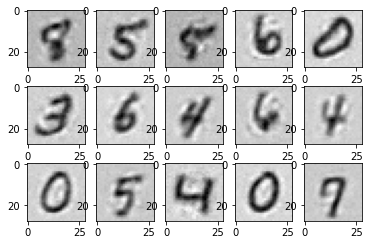

In [27]:
for i in range(1,16): 
    plt.subplot(3,5,i)
    plt.imshow(attack_result[i-1].reshape(28,28),cmap='gray_r')
#plt.title("reconstructed data")
plt.show()